### Intro
Really world problems usually involve complex anlysis on big data. In this lab, we will introduce some useful functions to help complex data analysis.

In [43]:
import xarray as xr
import numpy as np # you can use numpy functions with xarray objects
import salem # this will help with plotting/projection 
import cartopy.crs as ccrs # an alternative way to handle plotting/projection yourself
import glob # a library to handle path/folder/file related issues
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

In [44]:
# Importing the data
u_file='/mnt/data/MetService_WRF/U_20000101000000.nc'
v_file='/mnt/data/MetService_WRF/V_20000101000000.nc'
t_file = '/mnt/data/MetService_WRF/T_20000101000000.nc'
smois_file = '/mnt/data/MetService_WRF/SMOIS_20000101000000.nc'
chunks={"height":1,"time":100}
ds_u = xr.open_dataset(u_file,chunks=chunks)
ds_v = xr.open_dataset(v_file,chunks=chunks)
ds_t = xr.open_dataset(t_file,chunks=chunks)
ds_s = xr.open_dataset(smois_file,chunks=chunks)

### Masking

#### Masking is a powerful tool, consider it as a if-else but for a multi dimensional data.

Two ways of using the mask function, either ds.where/da.where or xr.where. You can apply mask on either the whole dataset or on a single dataarray. xr.where gives you more flexibility of assigning values to both true and false conditions

Let's first use soil moisture to remove water from the figure/data.

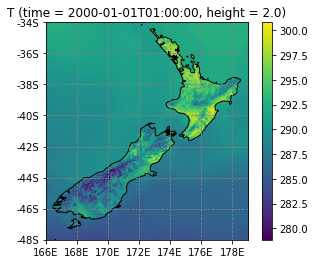

In [45]:
# This is the original map of soil moisture, and it shows the ocean which we want to mask out.
ds_t.T[0,1,...].salem.quick_map()

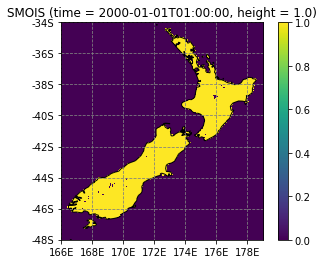

In [46]:
# This shows if you filter for less than 0.9 soil moisture, the ocean still unfortunately shows
(ds_s.SMOIS[0,1,...]<0.9).salem.quick_map()

In [47]:
# Mask the dataset so that there are only soil moisture values less than 0.9. Used to determine if land or is ocean (as ocean is 1 clearly!)
mask = ds_s.SMOIS[0,1,...]<0.9
# Even though the mask is applied on the soil moisture dataset, the 2D dimensions are the same for the air tempertaure and hence can be masked to that!
ds_t_land=ds_t.where(mask)

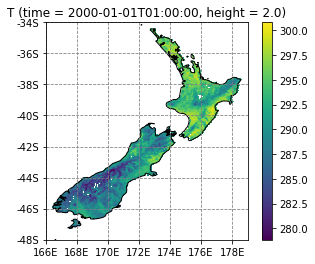

In [48]:
# And now we we have the map which has all vlaues over 0.9 as null! Which makes it look nice
ds_t_land.T[0,1,...].salem.quick_map()

#### Now let's only look at the wind speed distribuation at the locations where they have top 30% quantile of the monthly mean temperature

In [49]:
def calculate_ws_wd(u,v):
    """
    Function that calculates the windspeed and direction (angle)
    """
    wspeed = xr.ufuncs.sqrt(u*u + v * v)
    wdir   = (270-xr.ufuncs.arctan2(v,u)* 180/ np.pi)%360
    wspeed.name = "wind speed"
    wdir.name = "wind dir"
    wspeed.attrs["units"] = "m/s"
    return wspeed, wdir

/tmp/ipykernel_4095351/78132741.py:5: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  wspeed = xr.ufuncs.sqrt(u*u + v * v)
/opt/conda/envs/baseline/lib/python3.8/site-packages/xarray/core/dataarray.py:3068: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))
/tmp/ipykernel_4095351/78132741.py:6: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  wdir   = (270-xr.ufuncs.arctan2(v,u)* 180/ np.pi)%360
/opt/conda/envs/baseline/lib/python3.8/site-packages/xarray/core/dataarray.py:3088: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self.variable, other_variable)
/opt/conda/envs/baseline/lib/python3.8/site-packages/xarray/core/variable.py:2420: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self_data, other_data) if not reflexive else f(other_data, self_data)


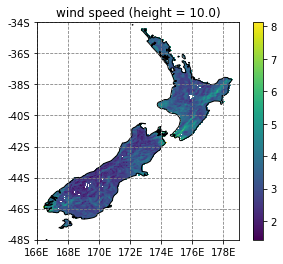

In [50]:
# Determine the windspeed and wind direction
wspeed, wdir = calculate_ws_wd(ds_u.U,ds_v.V)

# And then mask it to land and plot average wspeed
wspeed.where(mask).mean(dim=["time"]).isel(height=0).salem.quick_map()

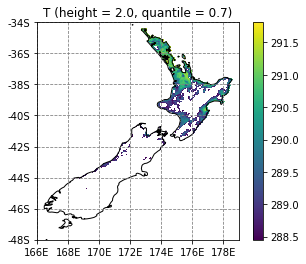

In [51]:
# Compare the mean of the wind speeds to the requested quantile (top 30% windspeeds) in order to plot them
wspeed_mean = ds_t_land["T"].isel(height=0).mean(dim="time")
wspeed_mean.where(wspeed_mean>wspeed_mean.quantile(0.7)).salem.quick_map() # Any vlaues above the quantile are ones we want

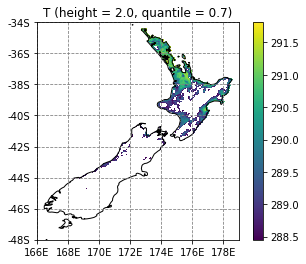

In [52]:
# Do the same for air temperature
ds_t_land_surf_mean = ds_t_land["T"].isel(height=0).mean(dim="time")
ds_t_land_surf_mean.where(ds_t_land_surf_mean>ds_t_land_surf_mean.quantile(0.7)).salem.quick_map()

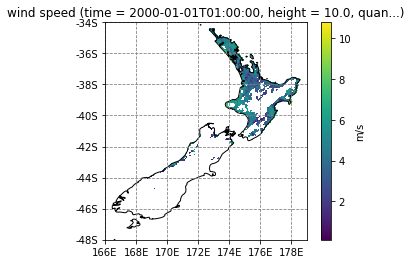

In [53]:
high_temperature_mask = xr.where(ds_t_land_surf_mean>ds_t_land_surf_mean.quantile(0.7),True,False)
wspeed.where(high_temperature_mask)[0,1,].salem.quick_map()

### Resample

Resampling is another technique that commonly used in data anlysis. For example, if you have a station that observes air pollution hourly, you need to use resample to get daily/monthly/yearly pollution information.

Get daily average, max and min temperature

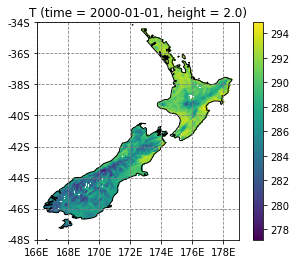

In [54]:
# Note: When you do resample and then mean (for example), you don't lose the dimension (whatever one you were averaging, most liekly time) where as directly applying mean would!

# Instead of hourly measurements, we want to resample into daily data so we can take the mean of that instead
# It does this by group by day. It does not print out nicely, as you have to tell it how to resample, eg resample by taking average of each day, max of each day, min of each day.
ds_t_land.resample(time="1D").mean(dim="time").T[0,0].salem.quick_map()

In [40]:
# Instead of reduction, we can change from hourly data to even finer data such as 10 seconds.
ds_t_land.resample(time="10S").interpolate()

<xarray.Dataset>
Dimensions:  (height: 10, time: 267481, lat: 508, lon: 472)
Coordinates:
  * lat      (lat) float64 -48.0 -47.97 -47.94 -47.92 ... -34.06 -34.03 -34.01
  * lon      (lon) float64 166.0 166.0 166.1 166.1 ... 178.9 178.9 179.0 179.0
  * height   (height) float64 2.0 20.0 30.0 40.0 ... 100.0 120.0 150.0 200.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-31T23:00:00
Data variables:
    T        (height, time, lat, lon) float32 dask.array<chunksize=(1, 267481, 508, 472), meta=np.ndarray>

### Groupby
groupby function is another useful tool which gives you more flexibility to group/subsample data.

In [73]:
# Makes a new column to group by hour, and then average over that day
# "time.day" access the datetime library to calculate the day number of the "time" column. Other choices also include "time.week", "time.hour", "time.second" etc. You can also pass in the values to groupby, eg ds_t_land.time.dt.day which will also groupby day number
ds_t_land.groupby("time.day").mean(dim="time")

,Array,Chunk
Bytes,283.55 MiB,0.91 MiB
Shape,"(31, 10, 508, 472)","(1, 1, 508, 472)"
Count,1898 Tasks,310 Chunks
Type,float32,numpy.ndarray


In [ ]:
ds_t_land.groupby("time.day").mean(dim="time").T[0,0].salem.quick_map() # Same as the resample example, you can also use ds_t_land.time.dt.day inside groupby

In [192]:
ds_t_land.groupby("time.hour").mean(dim="time") #Hourly composit

,Array,Chunk
Bytes,219.52 MiB,0.91 MiB
Shape,"(24, 10, 508, 472)","(1, 1, 508, 472)"
Count,5348 Tasks,240 Chunks
Type,float32,numpy.ndarray


In [169]:
ds_t_land.groupby(ds_t_land.time.dt.hour).mean(dim="time")  ##groupby basically takes a categorical data and group the original data based on the input categorical data. 

,Array,Chunk
Bytes,219.52 MiB,0.91 MiB
Shape,"(24, 10, 508, 472)","(1, 1, 508, 472)"
Count,5348 Tasks,240 Chunks
Type,float32,numpy.ndarray


In [187]:
ds_t_land.T.groupby(high_temperature_mask).mean(dim=["height",'stacked_lat_lon']).values # this line calculates the average temperature of the hight/low category based on high_temperature_mask

/opt/conda/envs/baseline/lib/python3.8/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


array([[287.38727, 293.30856],
       [287.92572, 293.63278],
       [288.34726, 293.87234],
       ...,
       [281.20114, 287.91104],
       [282.13696, 288.5284 ],
       [283.0919 , 289.06656]], dtype=float32)

### Other functions

In [16]:
# Will reduce the spatial resultion by 10 times. However as the spatial grid is 508x472 (lat, lon) then the ones that dont fall into the categories (eg 8 x 2 residuals) are then trimmed off.
ds_t_land.coarsen(lat=10,lon=10,boundary="trim").max()

In [ ]:
# Creates a rolling "window" that will perform the task/method (eg mean) over values (from index) [0, 24] and then [1, 25] and then [2, 26] ...
# Think of this as the "Average mean over 24 days after the date". Basically smoothes the data.
ds_t_land.rolling(time=24).mean()

### Task

Calculate hourly composite average of wind speed, direction, temperature.